# **Rami KOCO - 170255063**


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.applications.densenet import DenseNet169
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from sklearn.metrics import classification_report, confusion_matrix
import tqdm
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainPath='./drive/MyDrive/Data/train/'
testPath='./drive/MyDrive/Data/test/'
valPath='./drive/MyDrive/Data/train/'
classes = ['COVID-19/','Normal/','Pneumonia-Bacterial/','Pneumonia-Viral/']

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = trainPath,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = valPath,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = testPath,
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)
model_DenseNet169 = DenseNet169(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in model_DenseNet169.layers:
    layer.trainable = False

Found 7364 images belonging to 4 classes.
Found 7364 images belonging to 4 classes.
Found 673 images belonging to 4 classes.
51888128/51877672 [==============================] - 5s 0us/step


In [ ]:
x = model_DenseNet169.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = "softmax")(x)
model = Model(inputs= model_DenseNet169.input , outputs = x)

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5)

Epoch 1/5
116/116 [==============================] - 1623s 14s/step - loss: 6.4401 - accuracy: 0.8550 - precision: 0.7153 - recall: 0.6976 - auc: 0.8569 - val_loss: 0.5028 - val_accuracy: 0.8955 - val_precision: 0.8321 - val_recall: 0.7294 - val_auc: 0.9547
Epoch 2/5
116/116 [==============================] - 410s 4s/step - loss: 0.4705 - accuracy: 0.9034 - precision: 0.8296 - recall: 0.7724 - auc: 0.9600 - val_loss: 0.4223 - val_accuracy: 0.9135 - val_precision: 0.8524 - val_recall: 0.7907 - val_auc: 0.9678
Epoch 3/5
116/116 [==============================] - 405s 4s/step - loss: 0.4432 - accuracy: 0.9090 - precision: 0.8388 - recall: 0.7873 - auc: 0.9638 - val_loss: 0.4204 - val_accuracy: 0.9147 - val_precision: 0.8478 - val_recall: 0.8028 - val_auc: 0.9676
Epoch 4/5
116/116 [==============================] - 404s 3s/step - loss: 0.4356 - accuracy: 0.9084 - precision: 0.8346 - recall: 0.7901 - auc: 0.9649 - val_loss: 0.4105 - val_accuracy: 0.9204 - val_precision: 0.8547 - val_recall:

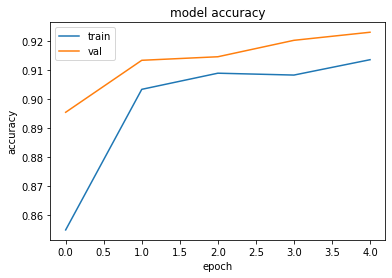

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

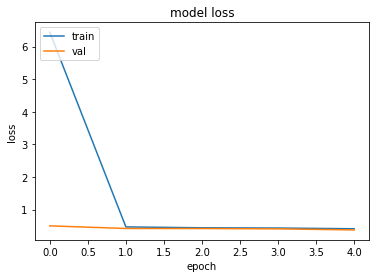

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def test_Xy(data):
    data.reset()
    X, y = next(data)
    for i in tqdm.tqdm(range(int(data.n/data.batch_size)-1)): 
        img, label = next(data)
        X = np.append(X, img, axis=0 )
        y = np.append(y, label, axis=0)
    return X,y

In [ ]:
X_test,y_test = test_Xy(test_dataset)

100%|██████████| 9/9 [02:02<00:00, 13.60s/it]


In [ ]:
print('X_test:',X_test.shape,'y_test:',y_test.shape)

X_test: (640, 224, 224, 3) y_test: (640, 4)


In [ ]:
y_pred  = np.round(model.predict(X_test))

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.89      0.98      0.93       178
           2       0.80      0.77      0.78       289
           3       0.69      0.51      0.59       160

   micro avg       0.81      0.77      0.79       640
   macro avg       0.85      0.81      0.83       640
weighted avg       0.80      0.77      0.78       640
 samples avg       0.77      0.77      0.77       640



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


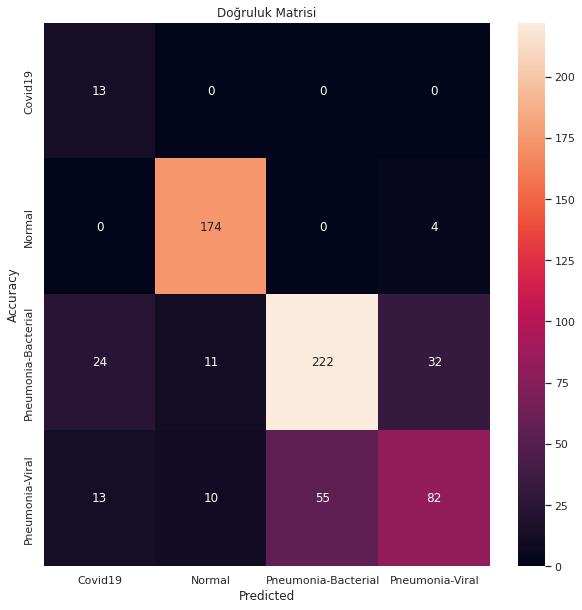

In [ ]:
import seaborn as sns

labels = ['Covid19','Normal','Pneumonia-Bacterial','Pneumonia-Viral']    

ax= plt.subplot()
sns.set(rc = {'figure.figsize':(10,10)})

cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('Accuracy'); 
ax.set_title('Doğruluk Matrisi'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);